<a href="https://colab.research.google.com/github/chokun7788/PoopforAIB/blob/main/Copy_of_FirstStepForTrainPoop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# กำหนดเส้นทางของข้อมูล
base_dir = '/content/drive/MyDrive/RealPooP'  # เส้นทางของ dataset ที่คุณเก็บไว้
train_dir = '/content/drive/MyDrive/processed/train/'
valid_dir = '/content/drive/MyDrive/processed/valid/'
test_dir = '/content/drive/MyDrive/processed/test/'

# สร้างโฟลเดอร์หากไม่มี
for dir_name in [train_dir, valid_dir, test_dir]:
    os.makedirs(dir_name, exist_ok=True)

# สร้างโฟลเดอร์ย่อยสำหรับแต่ละคลาส
for class_name in ['Normal', 'Blood', 'Diarrhea', 'Green', 'Yellow','Mucus']:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# ตรวจสอบจำนวนไฟล์ในแต่ละคลาส
for class_name in ['Normal', 'Blood', 'Diarrhea', 'Green', 'Yellow','Mucus']:
    class_dir = os.path.join(base_dir, class_name)
    all_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    print(f"{class_name}: {len(all_files)} ตัวอย่าง")

# แบ่งข้อมูลเป็น train, test, valid (70% train, 15% valid, 15% test)
for class_name in ['Normal', 'Blood', 'Diarrhea', 'Green', 'Yellow','Mucus']:
    # โฟลเดอร์คลาสที่ต้องการ
    class_dir = os.path.join(base_dir, class_name)
    all_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # แบ่งข้อมูล (ไม่ใช้ stratify เพื่อหลีกเลี่ยง class imbalance)
    train_files, temp_files = train_test_split(all_files, test_size=0.3)  # 70% train, 30% test+valid
    valid_files, test_files = train_test_split(temp_files, test_size=0.5)  # 50% สำหรับ test

    # ฟังก์ชันคัดลอกไฟล์
    def copy_files(file_list, source_dir, target_dir, class_name):
        for file_name in file_list:
            source_path = os.path.join(source_dir, file_name)
            target_path = os.path.join(target_dir, class_name, file_name)
            shutil.copy(source_path, target_path)

    # คัดลอกไฟล์ไปยังโฟลเดอร์ train, valid, test
    copy_files(train_files, class_dir, train_dir, class_name)
    copy_files(valid_files, class_dir, valid_dir, class_name)
    copy_files(test_files, class_dir, test_dir, class_name)

print("ข้อมูลถูกแบ่งและบันทึกเรียบร้อยแล้ว!")


Normal: 1820 ตัวอย่าง
Blood: 178 ตัวอย่าง
Diarrhea: 1457 ตัวอย่าง
Green: 137 ตัวอย่าง
Yellow: 443 ตัวอย่าง
Mucus: 182 ตัวอย่าง
ข้อมูลถูกแบ่งและบันทึกเรียบร้อยแล้ว!


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# กำหนดเส้นทางของข้อมูล
train_dir = '/content/drive/MyDrive/processed/train/'
valid_dir = '/content/drive/MyDrive/processed/valid/'
test_dir = '/content/drive/MyDrive/processed/test/'

# กำหนดการ Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# โหลดข้อมูล
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # ขนาดภาพที่โมเดลต้องการ
    batch_size=32,
    class_mode='categorical'  # เนื่องจากมีหลายคลาส
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# สร้างโมเดลโดยใช้ pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # ไม่ให้เทรนโมเดลที่ถูกฝึกมาแล้ว

# เพิ่มเลเยอร์เพิ่มเติมสำหรับการจำแนก
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # จำนวนคลาสที่ต้องการจำแนก

# สร้างโมเดล
model = Model(inputs=base_model.input, outputs=output)

# คอมไพล์โมเดล
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# เทรนโมเดล
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

# ทดสอบโมเดล
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc}")


Found 3906 images belonging to 6 classes.
Found 1714 images belonging to 6 classes.
Found 1686 images belonging to 6 classes.
Epoch 1/10


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 6), output.shape=(None, 5)

In [ ]:
import pandas as pd

# สมมติว่า `history` คือผลลัพธ์จากการเทรนโมเดล
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# สร้าง DataFrame สำหรับแสดงผล
epochs = range(1, len(train_accuracy) + 1)
df_accuracy = pd.DataFrame({
    'Epoch': epochs,
    'Train Accuracy': train_accuracy,
    'Validation Accuracy': val_accuracy,
})

# แสดงผล DataFrame ใน Colab
df_accuracy


,Epoch,Train Accuracy,Validation Accuracy
0,1,0.399123,0.349330
1,2,0.500000,0.345982
2,3,0.461201,0.541295
3,4,0.406250,0.551339
4,5,0.446694,0.535714
5,6,0.656250,0.551339
6,7,0.480769,0.506696
7,8,0.531250,0.497768
8,9,0.489204,0.506696
9,10,0.562500,0.522321


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# สมมติว่า y_true เป็น ground truth (label จริง) และ y_pred เป็นผลลัพธ์ที่โมเดลทำนาย
y_true = np.array([0, 1, 2, 2, 0, 1, 1, 2, 0, 1])  # ตัวอย่าง ground truth
y_pred = np.array([0, 0, 2, 2, 0, 1, 1, 1, 0, 2])  # ตัวอย่าง prediction

# คำนวณ metrics ต่างๆ
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # 'macro' เป็นการคำนวณแบบไม่ให้ความสำคัญกับคลาสใดคลาสหนึ่ง
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# แสดงค่า metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# แสดง confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix:\n{cm}")


Accuracy: 0.7000
Precision: 0.6944
Recall: 0.7222
F1 Score: 0.6984
Confusion Matrix:
[[3 0 0]
 [1 2 1]
 [0 1 2]]


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/processed/test/train/img1.jpg'

<Figure size 1000x500 with 0 Axes>

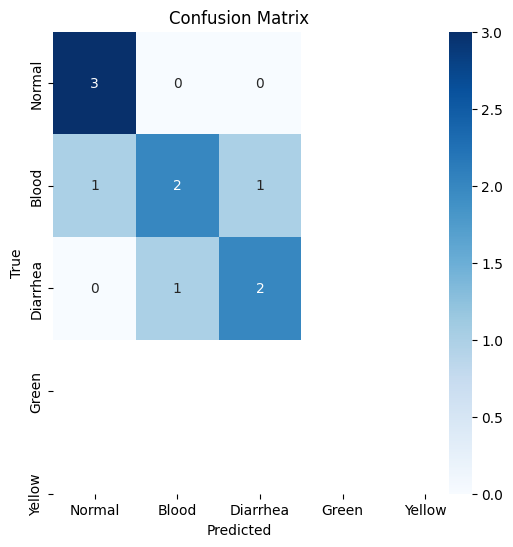

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# สมมติว่า y_true และ y_pred คือค่าของ ground truth และ prediction ที่ได้จากโมเดล
y_true = np.array([0, 1, 2, 2, 0, 1, 1, 2, 0, 1])  # คลาสจริง
y_pred = np.array([0, 0, 2, 2, 0, 1, 1, 1, 0, 2])  # ผลลัพธ์ที่โมเดลทำนาย

# คำนวณ confusion matrix
cm = confusion_matrix(y_true, y_pred)

# แสดงผลเป็น heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Blood', 'Diarrhea', 'Green', 'Yellow'], yticklabels=['Normal', 'Blood', 'Diarrhea', 'Green', 'Yellow'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

# ตัวอย่าง ground truth และ prediction (เปลี่ยนให้เป็น 2D array ที่เหมาะสม)
y_true = np.array([[1, 0, 0, 0, 0],  # Normal
                   [0, 1, 0, 0, 0],  # Blood
                   [0, 0, 1, 0, 0],  # Diarrhea
                   [0, 0, 0, 1, 0],  # Green
                   [0, 0, 0, 0, 1]]) # Yellow

y_pred = np.array([[1, 0, 0, 0, 0],  # Normal
                   [0, 1, 0, 0, 0],  # Blood
                   [0, 0, 1, 0, 0],  # Diarrhea
                   [0, 0, 0, 1, 0],  # Green
                   [0, 0, 0, 0, 1]]) # Yellow

# คำนวณ metrics
accuracy = accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
precision = precision_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average='weighted', zero_division=0)
recall = recall_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average='weighted', zero_division=0)
f1 = f1_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovr')

# แสดงผล
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC AUC: 1.0000


**F1Score**

In [ ]:
from sklearn.metrics import f1_score

# ทำนายผลลัพธ์จากชุดทดสอบ
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

# แปลงการทำนายให้เป็น class label
y_pred_labels = np.argmax(y_pred, axis=1)

# ดึงข้อมูล labels จริงจาก test_generator
y_true = test_generator.classes

# คำนวณ F1 Score
f1 = f1_score(y_true, y_pred_labels, average='weighted')
print(f"F1 Score: {f1:.4f}")


 7/28 ━━━━━━━━━━━━━━━━━━━━ 2:15 6s/step

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# ฟังก์ชันสำหรับคำนวณ F1 Score
def f1_score_metric(y_true, y_pred):
    # คำนวณ Precision และ Recall
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())

    # คำนวณ F1 Score
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

# คอมไพล์โมเดลด้วย F1 Score metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score_metric])

# เทรนโมเดล
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

# กำหนด path ของข้อมูล
train_data_dir = "/content/drive/MyDrive/processed/train"  # ระบุ path ที่เก็บข้อมูล
validation_data_dir = "/content/drive/MyDrive/processed/valid"  # ระบุ path ที่เก็บข้อมูล validation

# เตรียม Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# โหลดข้อมูลสำหรับการฝึก (train) และทดสอบ (validation)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 3906 images belonging to 6 classes.
Found 1714 images belonging to 6 classes.


In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# สร้างโมเดลโดยใช้ Pre-trained ResNet50 (ปิดใช้งาน fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers ของ ResNet50 เพื่อไม่ให้โมเดลแก้ไข weights ที่ฝึกไว้แล้ว
base_model.trainable = False

# สร้างโมเดลใหม่
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(6, activation='softmax')  # ปรับเป็นจำนวน class ที่ต้องการ
])

# คอมไพล์โมเดล
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# ฝึกโมเดล
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 1233s 10s/step - accuracy: 0.4158 - loss: 1.5110 - val_accuracy: 0.5035 - val_loss: 1.2530
Epoch 2/20
  1/122 ━━━━━━━━━━━━━━━━━━━━ 14:05 7s/step - accuracy: 0.4688 - loss: 1.3446

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


122/122 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - accuracy: 0.4688 - loss: 1.3446 - val_accuracy: 0.5483 - val_loss: 1.2413
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 1200s 10s/step - accuracy: 0.4862 - loss: 1.3090 - val_accuracy: 0.5442 - val_loss: 1.1785
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.3438 - loss: 1.5972 - val_accuracy: 0.5607 - val_loss: 1.1814
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 1224s 10s/step - accuracy: 0.5306 - loss: 1.2730 - val_accuracy: 0.5301 - val_loss: 1.2081
Epoch 6/20
  1/122 ━━━━━━━━━━━━━━━━━━━━ 11:32 6s/step - accuracy: 0.6875 - loss: 1.0336

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ทำนายผลโดยใช้ validation dataset
y_true = valid_generator.classes  # ค่า ground truth
y_pred = model.predict(valid_generator, steps=valid_generator.samples // valid_generator.batch_size, verbose=1)

# ตรวจสอบให้มั่นใจว่า y_pred ถูกแปลงให้เป็น index ของ class
y_pred = np.argmax(y_pred, axis=1)

# ตรวจสอบว่า y_true และ y_pred มีขนาดเท่ากัน
assert len(y_true) == len(y_pred), f"Length mismatch: y_true has {len(y_true)} elements, y_pred has {len(y_pred)} elements"

# คำนวณ metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovr')

# แสดงผล metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# แสดง Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# ตั้งค่าให้แสดง Confusion Matrix ด้วย heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


39/39 ━━━━━━━━━━━━━━━━━━━━ 255s 6s/step


AssertionError: Length mismatch: y_true has 1257 elements, y_pred has 1248 elements

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


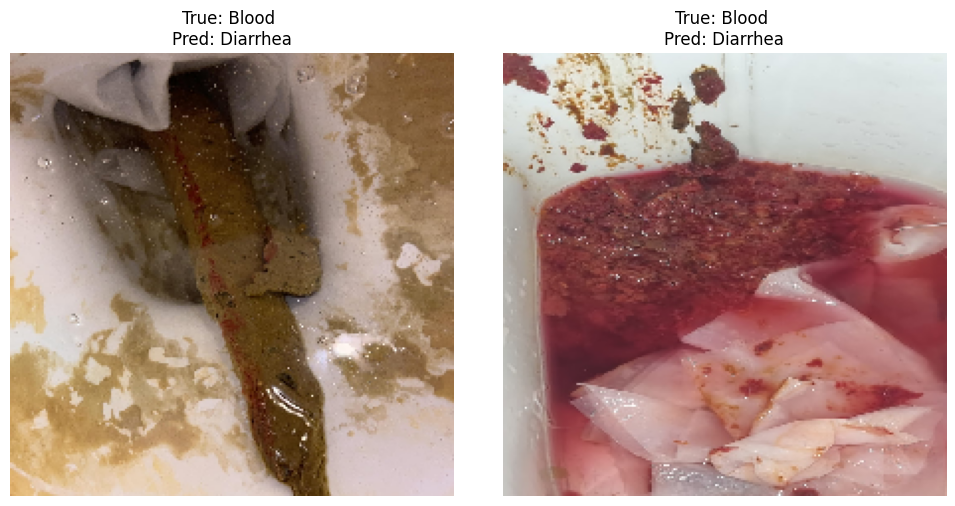

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


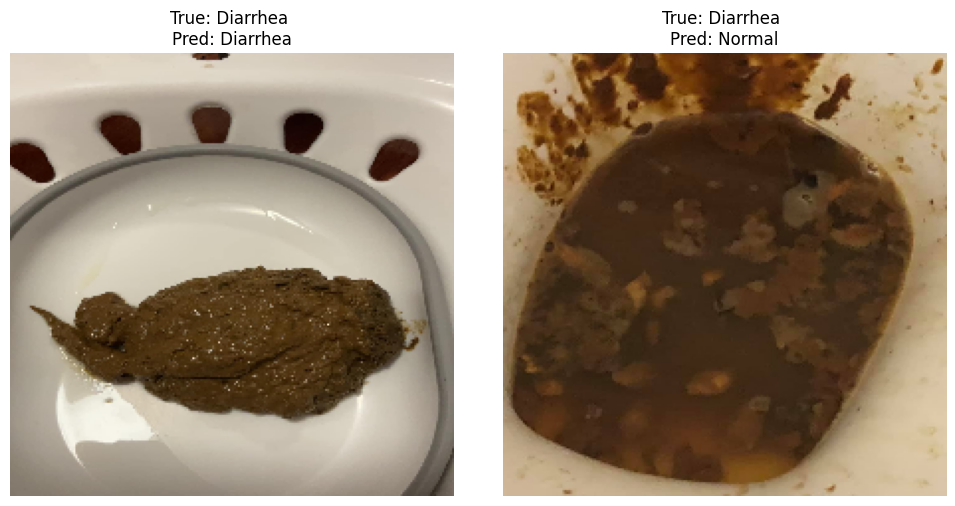

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


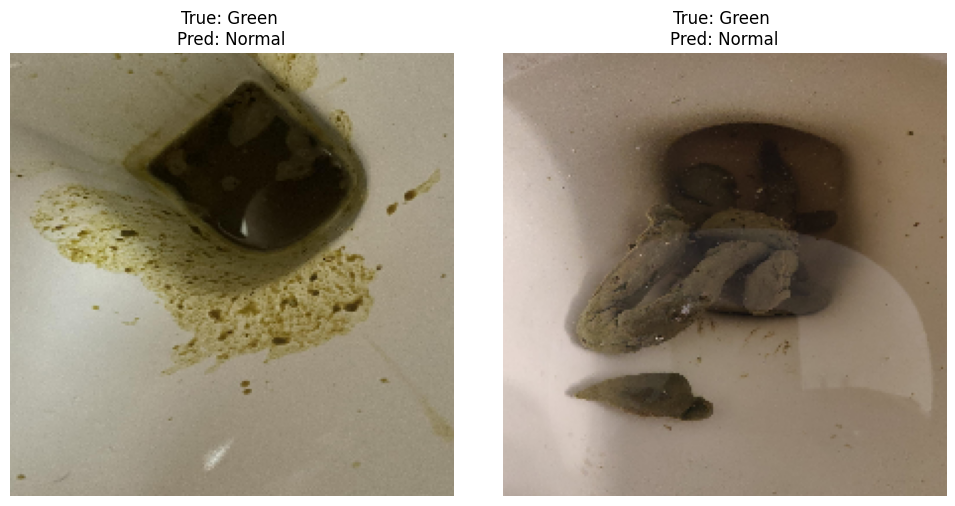

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


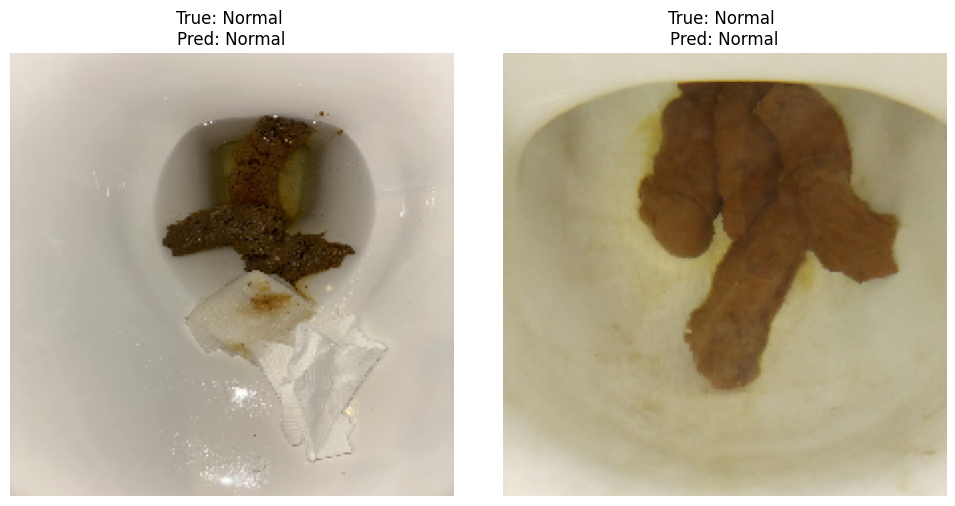

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


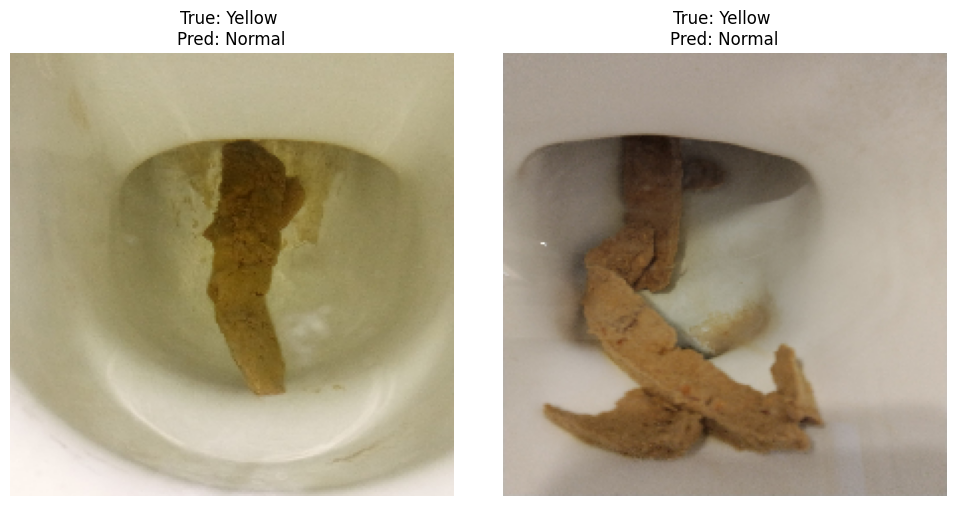

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# จำนวนรูปที่ต้องการสุ่มจากแต่ละคลาส
num_samples = 2

# สุ่มเลือกไฟล์จากแต่ละคลาส
class_names = list(valid_generator.class_indices.keys())  # แปลงเป็น list
for class_name in class_names:
    # กรองไฟล์ที่อยู่ในแต่ละคลาส
    class_files = [file for file in valid_generator.filenames if class_name in file]

    # สุ่มเลือก 2 รูปจากคลาสนี้
    selected_files = random.sample(class_files, num_samples)

    # แสดงรูปที่สุ่มเลือก
    plt.figure(figsize=(10, 5))
    for i, file_name in enumerate(selected_files):
        img_path = os.path.join(valid_generator.directory, file_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = np.array(img) / 255.0

        # ทำนายผล
        y_pred = model.predict(np.expand_dims(img_array, axis=0))
        pred_class = np.argmax(y_pred, axis=1)[0]
        true_class = valid_generator.classes[valid_generator.filenames.index(file_name)]

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_class]} \nPred: {class_names[pred_class]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
print(f"Number of validation samples: {valid_generator.samples}")


Number of validation samples: 1257
